<center><h1>Semantic Segmentation</h1></center>

<center><h2><a href="https://deepcourse-epita.netlify.app/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://gitlab.com/ey_datakalab/course_epita).

In [48]:
#!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#!tar -xf VOCtrainval_06-Nov-2007.tar

# !wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
# !tar -xf VOCtrainval_11-May-2012.tar

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import glob
import random

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as Fv
import torchvision
from PIL import Image

/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


---

In this colab, we are going to learn to do **semantic segmentation**. Instead of predicting one label (cat, dog, etc.) per image, we will predict one label *per pixel*!

Each pixel should belong to a class (cat, dog, etc.) or to a *background* class.

## Data Setup

**Pascal VOC 2007** is made of 20 classes. Each image can contain multiple objects. To simplify our task, we'll limit ourselves to `dog`, and `person` classes. However if you have more time, please try with all 20 classes. You'll get better results that way!

In [4]:
paths = []
classes = {
    #1: 'aeroplane',
    #2: 'bicycle',
    #3: 'bird',
    #4: 'boat',
    #5: 'bottle',
    #6: 'bus',
    #7: 'car',
    #8: 'cat',
    #9: 'chair',
    #10: 'cow',
    #11: 'diningtable',
    12: 'dog',
    #13: 'horse',
    #14: 'motorbike',
    15: 'person',
    #16: 'pottedplant',
    #17: 'sheep',
    #18: 'sofa',
    #19: 'train',
    #20: 'tvmonitor'
}

for gt_path in glob.glob("VOCdevkit/VOC2012/SegmentationClass/*png"):
  img = np.array(Image.open(gt_path)).reshape(-1)
  present_classes = np.unique(img)

  overlap = any([c in classes for c in present_classes])
  if overlap:
    paths.append(gt_path.split("/")[-1].split('.')[0])

len(paths), paths[:10]

(1085,
 ['2007_007048',
  '2010_002907',
  '2008_000700',
  '2011_002300',
  '2011_002327',
  '2009_001002',
  '2011_001015',
  '2009_001096',
  '2008_001137',
  '2010_002570'])

Always visualize data, especially in segmentation. Here each class is colorized differently, although we won't use all for this exercice.

Note also that the `background` is the class 0 in black. The class `unknown` is denoted in beige by the number 255. This later class will be discarded during training as it represents noisy pixels, often found on boundaries and may impair learning

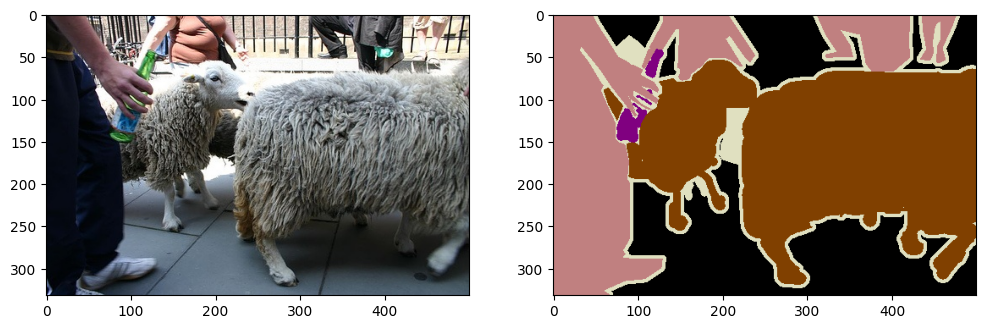

In [5]:
index = 0

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(f"VOCdevkit/VOC2012/JPEGImages/{paths[index]}.jpg"))
plt.subplot(1, 2, 2)
plt.imshow(Image.open(f"VOCdevkit/VOC2012/SegmentationClass/{paths[index]}.png"))

We now code a dataset and loader for our images and segmentation maps:

In [6]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, ids, transform=None):
    self.ids = ids

    self.transform = transform

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    img = Image.open(f"VOCdevkit/VOC2012/JPEGImages/{self.ids[index]}.jpg").convert("RGB")
    target = Image.open(f"VOCdevkit/VOC2012/SegmentationClass/{self.ids[index]}.png")

    img, target = self.transform(img, target)

    return img, target

We also need to define a target transform which will remove the undesired classes because we choose to limit ourselves to `person` and `dog`.

All others classes will be considered as "`background`" (aka class number 0).


In [7]:
class SelectClasses:
  def __init__(self, classes):
    self.classes = {0: 0, 255: 255}
    for i, c in enumerate(classes, start=1):
      self.classes[c] = i

  def __call__(self, x, y):
    return x, y.apply_(
        lambda c: self.classes.get(c, 0)
    )

Now, let's do some data augmentation to avoid overfitting on the train test.

Note that we need to code custom data augmentation here because any modification to the image should affect the ground-truth (called a "segmentation map").

For example, if I'm flipping horizontally the image (mirror effect), the "dog" that may have been on the left will now be on the right. Thus, I also need to flip the ground-truth so that pixels on the right are labeled as "dog".

Here are some data augmentations that apply the same augmentation to both the image and the target:

In [8]:
class Compose:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, x, y):
    for t in self.transforms:
      x, y = t(x, y)
    return x, y


class Resize:
  def __init__(self, size):
    self.size = size

  def __call__(self, x, y):
    x = Fv.resize(x, self.size, Image.BILINEAR)
    y = Fv.resize(y, self.size, Image.NEAREST)
    return x, y


class RandomHorizontalFlip:
  def __call__(self, x, y):
    if random.random() < 0.5:
      return Fv.hflip(x), Fv.hflip(y)
    return x, y 


class ToTensor:
  def __call__(self, x, y):
    return Fv.to_tensor(x), torch.from_numpy(np.array(y, dtype=np.uint8))


class Normalize:
  def __init__(self, mu, sigma):
    self.mu, self.sigma = mu, sigma

  def __call__(self, x, y):
    return Fv.normalize(x, self.mu, self.sigma), y


class RandomResizedCrop:
    """From https://github.com/fcdl94/MiB"""
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.BILINEAR):
        if isinstance(size, tuple):
            self.size = size
        else:
            self.size = (size, size)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")

        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio):
        area = img.size[0] * img.size[1]

        for attempt in range(10):
            target_area = random.uniform(*scale) * area
            log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback to central crop
        in_ratio = img.size[0] / img.size[1]
        if (in_ratio < min(ratio)):
            w = img.size[0]
            h = int(round(w / min(ratio)))
        elif (in_ratio > max(ratio)):
            h = img.size[1]
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = img.size[0]
            h = img.size[1]
        i = (img.size[1] - h) // 2
        j = (img.size[0] - w) // 2
        return i, j, h, w

    def __call__(self, img, lbl=None):
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        if lbl is not None:
            return Fv.resized_crop(img, i, j, h, w, self.size, self.interpolation), \
                   Fv.resized_crop(lbl, i, j, h, w, self.size, Image.NEAREST)
        else:
            return Fv.resized_crop(img, i, j, h, w, self.size, self.interpolation)

Datasets often provides predefined train/val/test splits. Moreover, the test set may not always be labeled in order to be used in competitions. So for preliminary experiments we rely solely on the train and val splits:

In [9]:
with open("VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt", "r") as f:
  train_ids = set(map(lambda x: x.strip(), f.readlines()))

with open("VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt", "r") as f:
  val_ids = set(map(lambda x: x.strip(), f.readlines()))

len(train_ids), len(val_ids)

(1464, 1449)

In [10]:
paths[:10]

['2007_007048',
 '2010_002907',
 '2008_000700',
 '2011_002300',
 '2011_002327',
 '2009_001002',
 '2011_001015',
 '2009_001096',
 '2008_001137',
 '2010_002570']

Now, let's build our loaders.

We are going to use, as it is very common to do, a ResNet pretrained on ImageNet as base model. Thus we also need to preprocess the image in the exact same way: we normalize the image with the ImageNet's mean and std.

We also resize the image to 224x224. The real size of Pascal-VOC images is 512x512. Larger sizes will give much better results, but it's also much slower...

In [11]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

val_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(imagenet_mean, imagenet_std),
    SelectClasses(list(classes.keys()))
])

train_transform = Compose([
    RandomResizedCrop((224, 224), (0.5, 2.0)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(imagenet_mean, imagenet_std),
    SelectClasses(list(classes.keys()))
])

train_paths = list(filter(lambda x: x in train_ids, paths))
val_paths = list(filter(lambda x: x in val_ids, paths))

train_dataset = Dataset(train_paths, train_transform)
val_dataset = Dataset(val_paths, val_transform)

test_dataset = val_dataset

print(f"{len(train_dataset)} train images and {len(test_dataset)} test images")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

len(train_loader), len(test_loader)

541 train images and 544 test images


(34, 34)

Quick check that the output of the loaders are correct:
- does the shape seems correct?
- does the values of the GT and image pixels seem correct?

In [12]:
x, y = next(iter(train_loader))

print('Shapes: ', x.shape, y.shape)
print('Classes: ', torch.unique(y))
print('Pixels values min/max: ', x.min(), x.max())

Shapes:  torch.Size([16, 3, 224, 224]) torch.Size([16, 224, 224])
Classes:  tensor([  0,   1,   2, 255], dtype=torch.uint8)
Pixels values min/max:  tensor(-2.1179) tensor(2.6400)


---

## FCN: Fully Convolutional Network

Now the network! We are going to re-use pretrained weights, but we want to discard the final classifier and the global pooling.

Ideally in a project, if you want to modify the architecture, the best is to copy the whole file (https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) in your project and directly modify it.

In this case, and because it's a colab, we are going to be dirty:
1. Monkey-patch the forward of the ResNet (our features extractor)
2. Wrap around it our whole model

After extracting the features from the ResNet, our classifier will be made only of convolutions. ergo the name "FCN: Fully Convolutional Network". This classifier will be made of

- a convolution producing 512 channels with a kernel size of 3. Choose the padding so that the spatial dimensions remain the same
- a batch norm
- a ReLU activation
- a dropout with 0.3 probability
- and a **pointwise** convolution producing `nb_classes` channels. A pointwise convolution has a kernel size of 1. Again choose the padding so that the spatial dimensions remain the same

Code yourself this FCN's classifier!

In [13]:
def forward_extract(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  x = self.maxpool(x)
  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)
  return x


class FCN(nn.Module):
  def __init__(self, nb_classes):
    super().__init__()

    self.resnet = torchvision.models.resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])
    self.resnet.forward = forward_extract.__get__(
        self.resnet,
        torchvision.models.ResNet
    )  # monkey-patching

    self.fc = nn.Sequential(
        nn.Conv2d(2048, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(512, nb_classes, kernel_size=1)
    )

  def forward(self, x):
    x = self.resnet(x)
    x = self.fc(x)

    return F.interpolate(
        x, size=(224, 224), mode="bilinear", align_corners=False
    )

In [14]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://deepcourse-epita.netlify.app/code/seg/fcn.py
# %pycat fcn.py

Notice that the end of classifier is quite small, and therefore we interpolate the predictions in order to have a predicted segmentation maps as large as the image.

Again, check that the forward doesn't crash and that the resulting shape is ok!

In [15]:
model = FCN(len(classes) + 1)

x = torch.randn(16, 3, 224, 224)
model(x).shape

/home/coartix/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coartix/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([16, 3, 224, 224])

---

## A Metric: Mean Intersection over Union

But a model is no good if we cannot measure its performance. 

In semantic segmentation, we can still have the class accuracy that you know. *e.g.* how many pixels of `person` were correctly correctly classified.

What is the limit to class accuracy in our situation?

- Overprediction! 

If we predict too much `person` on the background pixels, we'll probably have a high class accuracy. Our objective is thus to have a correct prediction, but also that the predicted mask overlap perfectly with the ground-truth mask.


This metric is called the **Intersection over Union (IoU)**, also known as the *Jaccard index*: https://en.wikipedia.org/wiki/Jaccard_index

It measures the intersection between predictions and ground-truth divided by the union.

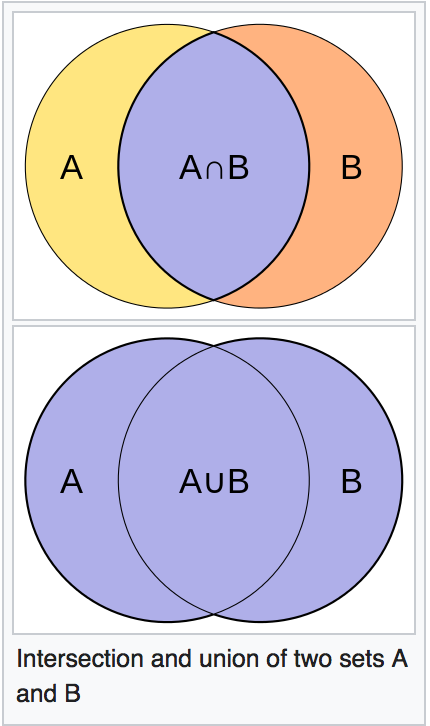

First, we build a (un-normalized) confusion matrix:

In [16]:
def confusion_matrix(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

Now, based on this confusion matrix, compute the intersection and the union.

Based on this, you should get the IoU per class, and once averaged you have the mIoU (with equal importance to all classes).

Complete this snippet of code:

In [17]:
def get_miou(conf_matrix):
    inter = torch.diag(conf_matrix)

    true = conf_matrix.sum(dim=1)
    pred = conf_matrix.sum(dim=0)

    union = true + pred - inter

    iou_per_class = inter / (union + 1e-6)
    miou = torch.mean(iou_per_class)
    return miou, iou_per_class

In [18]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://deepcourse-epita.netlify.app/code/seg/iou.py
# %pycat iou.py

Let's test it on some visual examples with square masks:

In [19]:
def test_iou(gt, pred):
  gt_mask = torch.zeros(10, 10).long()
  gt_mask[gt[0]:gt[0] + gt[2], gt[1]:gt[1] + gt[3]] = 1
  pred_mask = torch.zeros(10, 10).long()
  pred_mask[pred[0]:pred[0] + pred[2], pred[1]:pred[1] + pred[3]] = 1

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.set_ylim(0, 5)
  ax.set_xlim(0, 5)
  ax.add_patch(plt.Rectangle((gt[0], gt[1]), gt[2], gt[3], color='green', alpha=0.5));
  ax.add_patch(plt.Rectangle((pred[0], pred[1]), pred[2], pred[3], color='red', alpha=0.5));
  iou = get_miou(confusion_matrix(gt_mask, pred_mask, 2))[1][1].item()
  ax.set_title(f"IoU = {round(iou, 2)}")

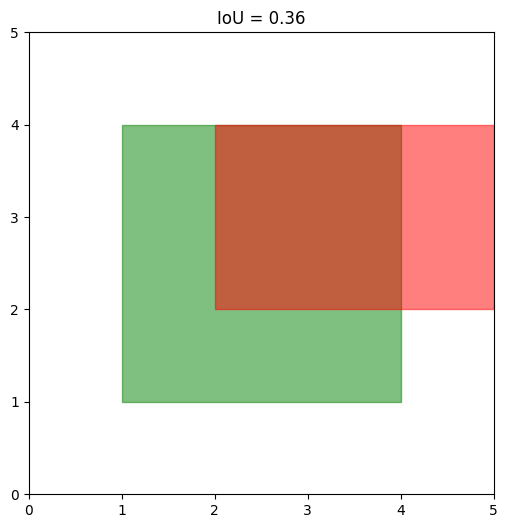

In [20]:
test_iou([1, 1, 3, 3], [2, 2, 3, 2])

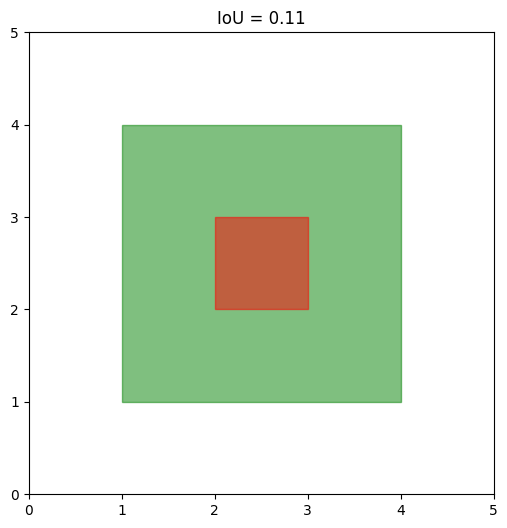

In [21]:
test_iou([1, 1, 3, 3], [2, 2, 1, 1])

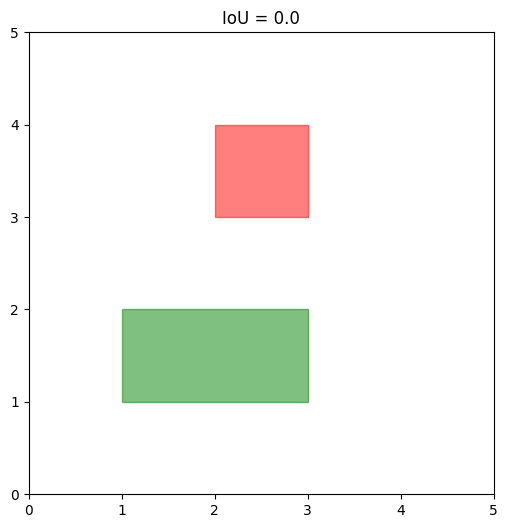

In [22]:
test_iou([1, 1, 2, 1], [2, 3, 1, 1])

---

## Let's Train!

In [23]:
def eval_model(net, loader):
  net.eval()
  all_miou, classes_miou, loss = 0., [0. for _ in range(len(classes) + 1)], 0.
  c = 0
  for x, y in loader:
    with torch.no_grad():
      # No need to compute gradient here thus we avoid storing intermediary activations
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y.long(), ignore_index=255).item()
    preds = logits.argmax(dim=1)
    for i, pred in enumerate(preds):
      _all_miou, _classes_miou = get_miou(confusion_matrix(y[i], pred, len(classes) + 1))
      all_miou += _all_miou.item()
      for class_index in range(len(classes_miou)):
        classes_miou[class_index] += _classes_miou[class_index].item()
    c += len(x)

  all_miou = round(100 * all_miou / c, 2)
  classes_miou = [round(100 * iou / c, 2) for iou in classes_miou]
  loss /= len(loader)
  net.train()
  return round(loss, 5), all_miou, classes_miou

In [44]:
model = FCN(len(classes) + 1).cuda()

In [25]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of parameters: 34,997,291


/tmp/ipykernel_10974/1602277651.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

for epoch in range(epochs):
  _loss, c = 0., 0

  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits, y.long(), ignore_index=255)

    loss.backward()
    optimizer.step()

    _loss += loss.item()
    c += len(x)

  print(f"Epoch {epoch}: train loss: {round(_loss / c, 5)}")

_, test_miou, test_mious = eval_model(model, test_loader)
print(f"Final mIoU: {test_miou}, and per class:")
print(f"\tBackground mIoU: {test_mious[0]}")
for i, class_name in enumerate(classes.values(), start=1):
  print(f"\t{class_name} mIoU: {test_mious[i]}")

Epoch 0: train loss: 0.03054
Epoch 1: train loss: 0.01544
Epoch 2: train loss: 0.01536
Epoch 3: train loss: 0.01252
Epoch 4: train loss: 0.01002
Epoch 5: train loss: 0.01063
Epoch 6: train loss: 0.01035
Epoch 7: train loss: 0.01135
Epoch 8: train loss: 0.01104
Epoch 9: train loss: 0.00917
Final mIoU: 46.74, and per class:
	Background mIoU: 89.22
	dog mIoU: 15.08
	person mIoU: 35.92


We can see that performance of `background` are really high. This is no surprise because this class is overpresent, so the model will be encouraged to only predict it.

The `person` class should be around 35% mIoU. It's far from perfect (ideally on Pascal-VOC we can reach easily above 60%), but we can see that the model has learned something.

The class `dog` is quite bad (around 13% for me).

Two insights important in semantic segmentation:
- some classes are easier than others. For example the class `bike` is super hard. This is why often research papers give their overall mIoU but also their mIoU per class.
- the class `person` is often good because it's over-represented compared to `dog`.

Now, that we have a naive FCN model, let's visualize its predictions!

In [26]:
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

voc_colormap = color_map()[:, None, :]


def colorize(image, array):
  new_im = np.dot(array == 0, voc_colormap[0])
  for i in range(1, voc_colormap.shape[0]):
    new_im += np.dot(array == i, voc_colormap[i])
  new_im = Image.fromarray(new_im.astype(np.uint8))
  return Image.blend(image, new_im, alpha=0.8) 

(1, 224, 224) torch.Size([1, 3, 224, 224])


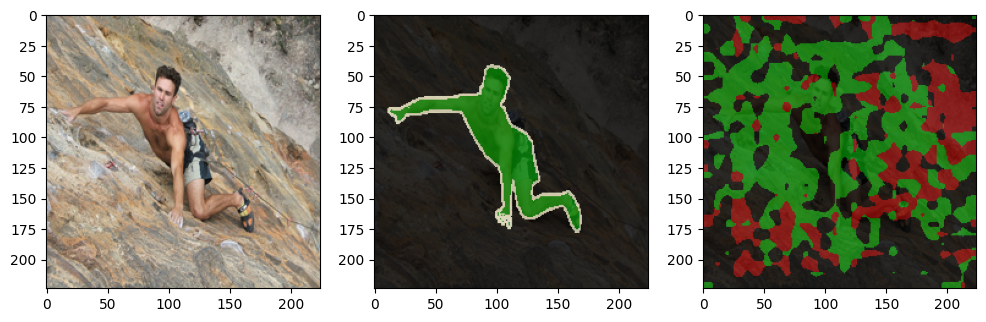

In [27]:
index = 0
path = val_paths[index]


image = Image.open(f"VOCdevkit/VOC2012/JPEGImages/{path}.jpg").convert("RGB")
image, target = val_transform(image, Image.open(f"VOCdevkit/VOC2012/SegmentationClass/{path}.png"))
with torch.no_grad():
  pred = model(image.cuda()[None]).cpu().argmax(dim=1).numpy().astype(np.uint8)

target = target.numpy()
image_jpg = Image.open(f"VOCdevkit/VOC2012/JPEGImages/{path}.jpg").resize((224, 224))

print(pred.shape, image[None].shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(image_jpg)
plt.subplot(1, 3, 2)
plt.imshow(colorize(image_jpg, target[..., None]))
plt.subplot(1, 3, 3)
plt.imshow(colorize(image_jpg, pred[0][..., None]))

The predictions of the class `person` is not that bad, except on the boundary. But note (try different images) that the model has the tendency to overpredict this class even where they are no `person`. 

Let's improve our FCN by incoporating a DeepLabv3 extention.

Multi-scale is the method of looking the same image but at different scales. You can look at an image by focusing on detais (small scales), but also by its ensemble (large scale).

Multi-scale is a very popular idea in computer vision, and especially in segmentation and object detection where the objects can have widely different sizes. (I've done it in one for my [paper](https://arxiv.org/abs/2011.11390)!)



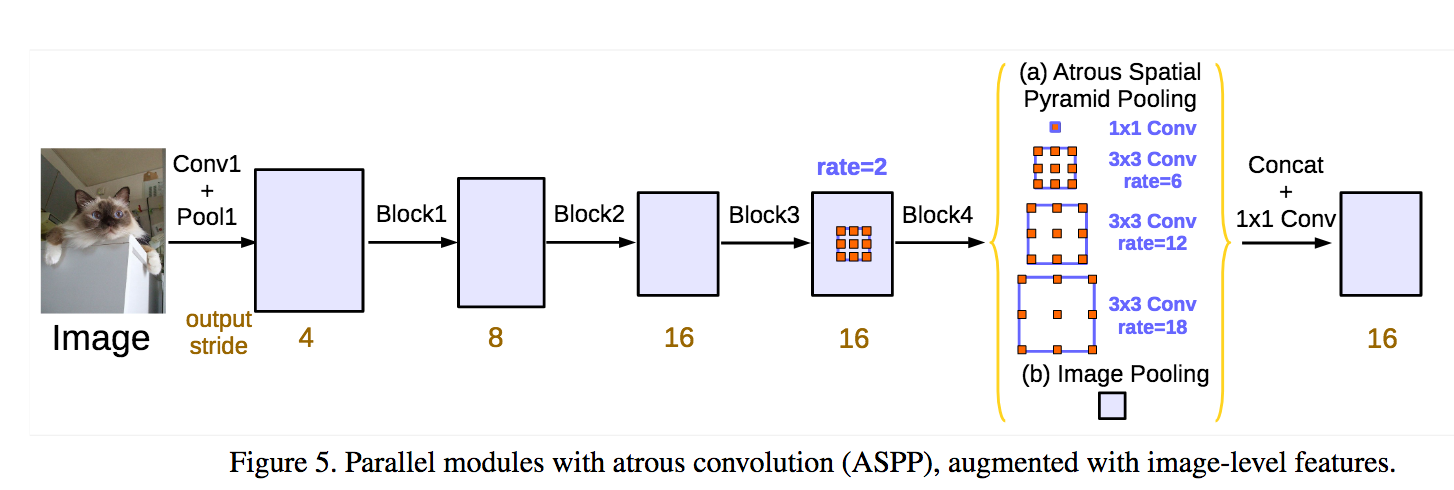

The DeepLabV3 (see paper [here](https://arxiv.org/abs/1706.05587) is made at first of the classical CNN backbone (we again use a ResNet50).

Then there is an **Atrous Spatial Pyramid Pooling** (ASPP) (Fig 5.a), and in parallel a global pooling (Fig 5.b). Similarly to inception, each output of the ASPP and global pooling will be concatenated together.

The ASPP is made of convolutions **a trous** (in French it means "*with holes*"). Those convolutions are also known as **dilated convolutions**:

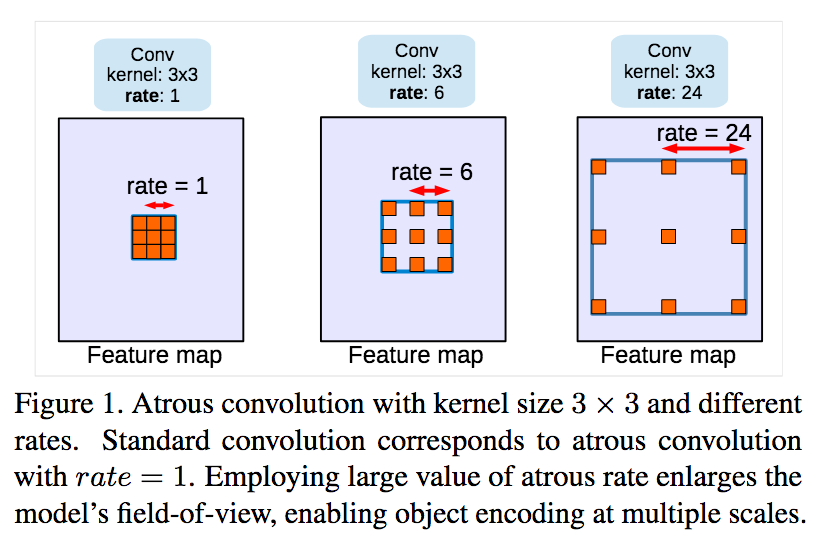

A dilated convolution has **zeros** inside the exploded kernels. Thus, the kernel becomes much larger without new parameters and can see a large patch of the features, and therefore has a larger **receptive field**.




You have two tasks:

1. ASPPConv module

This module implements the dilated convolution given a dilation rate.

It must have in this order:
- a convolution with dilation, use as much padding as dilation
- a batch norm
- a ReLU

2. Final projection

It takes the concatenation of all ASPPConvs and the ASSPooling, and:
- project it to `out_channels` with a **pointwise** (kernel 1x1) convolution
- batch norm
- ReLU

Good luck!

In [28]:
# You have nothing to do here, but you have a look

class DeepLabHead(nn.Sequential):
  def __init__(self, in_channels, num_classes):
      super(DeepLabHead, self).__init__(
          ASPP(in_channels, [6, 12, 18]),
          nn.Conv2d(256, 256, 3, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, num_classes, 1)
      )

class ASPPPooling(nn.Sequential):
  def __init__(self, in_channels, out_channels):
      super(ASPPPooling, self).__init__(
          nn.AdaptiveAvgPool2d(1),
          nn.Conv2d(in_channels, out_channels, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU())

  def forward(self, x):
      size = x.shape[-2:]
      for mod in self:
          x = mod(x)
      return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

In [29]:
# Complete the ASPP Conv here
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)

In [30]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://deepcourse-epita.netlify.app/code/seg/aspp_conv.py
# %pycat aspp_conv.py

In [31]:
# Complete the final projection here.
# Hint: try to understand how it is used in the `forward` method

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

In [32]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://deepcourse-epita.netlify.app/code/seg/aspp.py
# %pycat aspp.py

Now let's combine all together:

In [33]:
class DeepLab(nn.Module):
  def __init__(self, nb_classes):
    super().__init__()

    self.resnet = torchvision.models.resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])
    self.resnet.forward = forward_extract.__get__(
        self.resnet,
        torchvision.models.ResNet
    )  # monkey-patching

    self.deeplab = DeepLabHead(2048, nb_classes)

  def forward(self, x):
    x = self.resnet(x)
    x = self.deeplab(x)

    return F.interpolate(
        x, size=(224, 224), mode="bilinear", align_corners=False
    )

In [45]:
model = DeepLab(len(classes) + 1).cuda()

Notice that the number of parameters have significantly increased (34m -> 41m) compared to the basic FCN.

In [35]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of parameters: 41,683,243


/tmp/ipykernel_10974/1602277651.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

for epoch in range(epochs):
  _loss, c = 0., 0

  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits, y.long(), ignore_index=255)

    loss.backward()
    optimizer.step()

    _loss += loss.item()
    c += len(x)

  print(f"Epoch {epoch}: train loss: {round(_loss / c, 5)}")

_, test_miou, test_mious = eval_model(model, test_loader)
print(f"Final mIoU: {test_miou}, and per class:")
print(f"\tBackground mIoU: {test_mious[0]}")
for i, class_name in enumerate(classes.values(), start=1):
  print(f"\t{class_name} mIoU: {test_mious[i]}")

Epoch 0: train loss: 0.03302
Epoch 1: train loss: 0.01729
Epoch 2: train loss: 0.01553
Epoch 3: train loss: 0.01415
Epoch 4: train loss: 0.01174
Epoch 5: train loss: 0.01234
Epoch 6: train loss: 0.01088
Epoch 7: train loss: 0.01158
Epoch 8: train loss: 0.00973
Epoch 9: train loss: 0.00932
Final mIoU: 46.63, and per class:
	Background mIoU: 89.23
	dog mIoU: 13.29
	person mIoU: 37.37


Performance of `dog` is still bad, but the mIoU of `person` should have increased from 35% to 45%. A non-negligeable increase.

In [46]:
index = 0
path = val_paths[index]


image = Image.open(f"VOCdevkit/VOC2012/JPEGImages/{path}.jpg").convert("RGB")
image, target = val_transform(image, Image.open(f"VOCdevkit/VOC2012/SegmentationClass/{path}.png"))
with torch.no_grad():
  pred = model(image.cuda()[None]).cpu().argmax(dim=1).numpy().astype(np.uint8)

target = target.numpy()
image_jpg = Image.open(f"VOCdevkit/VOC2012/JPEGImages/{path}.jpg").resize((224, 224))

print(pred.shape, image[None].shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(image_jpg)
plt.subplot(1, 3, 2)
plt.imshow(colorize(image_jpg, target[..., None]))
plt.subplot(1, 3, 3)
plt.imshow(colorize(image_jpg, pred[0][..., None]))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

# Further

There are better architectures for segmentation but DeepLabV3 is a very popular and competitive one.

To get better results we should:
- use all classes
- use a lot more epochs
- schedule the learning rate so it is decreased gradually
- use a ResNet101